## Building a Self-Aware Classifier Using “IDK” Labels

As a bonus, in this notebook, we build an evaluation pipeline for generative models by combining a diffusion-based image generator with a self-aware MNIST classifier. Specifically, we first train an unconditionally guided UNet/DDPM model on the MNIST training dataset to generate handwritten digit images. This generative model follows the methodology introduced in the NVIDIA Generative AI with Diffusion Models course assessment [Generative AI with Diffusion Models](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+C-FX-08+V1) course assessment and the notebook prvided by the course intructor.

To assess the quality of the generated images, we then load a multiclass MNIST classifier that was trained on a curated version of the MNIST dataset augmented with an additional `“IDK”` (I Don’t Know) label. During the construction of this dataset, samples belonging to the top **20% quantiles of hardness and mistakenness** were relabeled as `IDK`, encouraging the classifier to explicitly abstain from uncertain predictions rather than forcing a potentially unreliable class assignment.

This modification makes the classifier more self-aware, allowing it to flag ambiguous or low-confidence inputs. Such predictions can be deferred to a human expert or used to analyze the aleatoric uncertainty present in both real and generated data. We then visually inspect the resulting predictions using the FiftyOne app. Finally, the test set—along with its predictions and associated metadata—is exported as a FiftyOne dataset, which serves as a structured evaluation resource for further qualitative and quantitative analysis of the model’s performance.

In the following cell, we import modules and functions from our `src` package, set random seeds for reproducibility, and define the parameters and file paths used throughout the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import wandb
import random
import warnings
import pandas as pd

# On a multi-GPU system, this hides all GPUs except the first 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

from torchvision import datasets, transforms
from huggingface_hub import snapshot_download
from torch.utils.data import DataLoader, Subset
from IPython.display import display, HTML

# Custom modules
from handsoncv.models import MnistClassifier, UNet
from handsoncv.datasets import GeneratedMNISTDataset
from handsoncv.training import train_diffusion
from handsoncv.evaluation import Evaluator
from handsoncv.metrics import calculate_idk_metrics, find_optimal_threshold
from handsoncv.utils import (
    DDPM,
    set_seed, 
    _test_multiclass_mnist_classifier,
    predict_with_cascaded_idk
)
from handsoncv.visualization import (
    plot_bonus_tsk_confidence_distribution, 
    plot_bonus_tsk_acc_coverage_curve
)

# Hardware & Paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-3")
ROOT_PATH_MULTICLASS = os.path.join(PROJECT_ROOT, "Assignment-1")
ROOT_DATA = os.path.join(ROOT_PATH, "data")
SAMPLE_DIR = f"{ROOT_DATA}/05_mnist_images"
CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
# ! First Assignment Checkpoint Folder for Multiclass/Binary/Baseline trained on MNIST & MNIST+IDK !
CHECKPOINTS_DIR_MULTICLASS = os.path.join(ROOT_PATH_MULTICLASS, "checkpoints")
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Numpy and Torch Reproducibility
SEED=42
set_seed(42)

# Base Configuration Parameters
BATCH_SIZE_CLASSIFIER = 64
BATCH_SIZE_DDPM = 128
IMG_SIZE = 28 # required for UNet/DDPM model 
EVAL_SUBSET_SIZE = 10000 # Size of generated images set and test subset
HF_REPO_ID = "vanessaguarino/mnist-confidence-thresholded-evaluation"

cuda
Seeds set to 42 for reproducibility.


### Data & Multiclass Classifier Loading 

In this section, we load the MNIST classifier checkpoint used in **Assignment-1** of this repository. The MNIST classifier is implemented in the `src/models` module and corresponds to a modified LeNet-5 architecture, as trained and evaluated in the `Assignment-1` notebook. 

The network follows the classical LeNet design with three convolutional layers and max-pooling operations, followed by two fully connected layers. Compared to the original formulation, dropout is introduced to improve regularization, and the final classification layer outputs raw class logits for the 11 MNIST digit classes. In addition, the architecture exposes an intermediate fully connected layer (120 → 84) as a hook point for extracting semantic embeddings, for downstream analysis and visualization.

> **Note:** We deliberately adopt a **multiclass classifier** for this evaluation. The ablation study conducted in **Assignment-1** showed that the multiclass formulation with an explicit *IDK* label more effectively learns the *IDK* class compared to both binary and multilabel alternatives, while still retaining higher accuracy on the individual digit classes.  
>  
> To mitigate the strong class imbalance between the *IDK* class and the remaining classes, the model was trained using **weighted sampling** and **focal loss**.

In [2]:
mnist_idk_multi_classifier = MnistClassifier(num_classes=11).to(DEVICE)
mnist_idk_multi_classifier.load_state_dict(torch.load(f"{CHECKPOINTS_DIR_MULTICLASS}/level_20/best_multiclass.pth"))
mnist_idk_multi_classifier.eval()
mnist_idk_multi_classifier

MnistClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In the next cell, we prepare the datasets and corresponding DataLoaders for both the UNet/DDPM generative model and the MNIST classifier. We create three DataLoaders:

1. DDPM Training DataLoader: Contains the full MNIST training split, transformed and resized for the UNet/DDPM model.
    - The MNIST training split is downloaded via `torchvision.datasets` and resized to the DDPM input size.
    - Pixel values are normalized to $[-1, 1]$ for compatibility with the diffusion model.
2. DDPM Validation DataLoader: A small portion (5%) of the MNIST training data is held out to validate the DDPM model during training.
    - A random 95/5 split is created to define training and validation subsets for DDPM training.
    - PyTorch `DataLoader`s are created for both subsets with batching, shuffling, and pinned memory for efficient training.
3. Classifier Test DataLoader: A subset of the MNIST test set is used to evaluate the pretrained classifier’s baseline accuracy before introducing the “IDK” mechanism.
    - The MNIST test split is loaded using standard classifier transforms: conversion to tensors and normalization using the MNIST mean and standard deviation.
    - A random subset of `EVAL_SUBSET_SIZE` samples is extracted from the test set to evaluate the classifier’s baseline accuracy.
    - We verify that all digits `0–9` are represented in the evaluation subset.
    - A `DataLoader` is created for this evaluation subset without shuffling to preserve consistent ordering during accuracy assessment.

To ensure reproducibility, a `torch.Generator` object is created and seeded with a fixed random seed, which is then passed to the DataLoader. Finally, a PyTorch `DataLoader` is created to efficiently batch and load the data during inference.

**Summary of DataLoaders**

| DataLoader                  | Purpose                                      | Dataset Size |
|------------------------------|---------------------------------------------|--------------|
| `train_loader_ddpm`          | DDPM model training                         | Full MNIST training set |
| `val_loader_ddpm`            | DDPM model validation                       | 5% of training set |
| `test_loader_classifier`     | Evaluate pretrained MNIST classifier        | Subset of MNIST test set (`EVAL_SUBSET_SIZE`) |

In [3]:
# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

# Define common train/valid/test dataloaders kwargs
train_kwargs = {'num_workers': 2, 'pin_memory': True, 'shuffle': True, 'drop_last': True}
test_kwargs = {'num_workers': 2, 'pin_memory': True, 'shuffle': False}

# Base transforms used for UNet/DDPM Model
transform_ddpm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Base transforms used for Mnist Classifier
transform_classifier = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Download MNIST dataset into `../data/` folder and instantiate it via `torchvision.datasets` for DDPM Training
train_dataset_ddpm = datasets.MNIST(ROOT_DATA, train=True, download=True, transform=transform_ddpm)
# We define a split of the training data to extract a small portion to validate on while training the UNet/DDPM Model
dataset_size = len(train_dataset_ddpm)
indices = list(range(dataset_size))
split = int(0.95 * dataset_size)

# Shuffle indices once
random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]

# Create train/validation subsets for DDPM
train_dataset_ddpm_split = Subset(train_dataset_ddpm, train_indices)
val_dataset_ddpm_split   = Subset(train_dataset_ddpm, val_indices)

# DDPM DataLoaders
train_loader_ddpm = DataLoader(train_dataset_ddpm, batch_size=BATCH_SIZE_DDPM, **train_kwargs, generator=g)
val_loader_ddpm = DataLoader(val_dataset_ddpm_split, batch_size=BATCH_SIZE_DDPM, **test_kwargs, generator=g)

# Prepare dataset test split; we will use only the test set to evaluate the pretrained Mnist Classifier
test_dataset_classifier = datasets.MNIST(ROOT_DATA, train=False, transform=transform_classifier, download=True)

# Sample 1000 images from the test split
test_indices = list(range(len(test_dataset_classifier)))
subset_indices = random.sample(test_indices, EVAL_SUBSET_SIZE)
eval_subset_real = Subset(test_dataset_classifier, subset_indices)

# Extract the labels contained in the subset to generate images that reproduce only that subset of labels  
eval_labels = [test_dataset_classifier[i][1] for i in subset_indices]

# Check that eval_labels contains all digits 0–9
expected_digits = set(range(10))
present_digits = set(eval_labels)

missing_digits = expected_digits - present_digits

if missing_digits:
    warnings.warn(
        f"eval_labels does not contain all digits 0–9. "
        f"Missing digits: {sorted(missing_digits)}",
        UserWarning
    )

test_loader_classifier = DataLoader(eval_subset_real, batch_size=BATCH_SIZE_CLASSIFIER, **test_kwargs, generator=g)

print(f"DDPM train samples:         {len(train_loader_ddpm.dataset)}")
print(f"DDPM val samples:           {len(val_loader_ddpm.dataset)}")
print(f"Classifier test samples:    {len(test_loader_classifier.dataset)}")

DDPM train samples:         60000
DDPM val samples:           3000
Classifier test samples:    10000


We first evaluate the model’s accuracy on the full MNIST test set to establish a baseline, which will serve as a reference point for assessing the impact of introducing “IDK” predictions during inference.

In [4]:
_test_multiclass_mnist_classifier(mnist_idk_multi_classifier, DEVICE, test_loader_classifier)


Test set results:
Average Loss: 0.3944
Accuracy (excluding IDK): 0.9959 (99.59%)
Total samples: 10000
IDK predictions: 1004 (10.04%)
Mistakes avoided by IDK: 1004
Misclassified digits (non-IDK): 37



### Part 2 — MNIST Digits Generation, Embedding Extraction, Evaluation via Multiclass Classifier Accuracy

In Part 2, we train an **unconditionally guided UNet-DDPM** to generate MNIST digits. The model learns to map noise to the digit distribution without class conditioning, using 300 diffusion timesteps, a linear noise schedule, and a UNet with three downsampling stages and a bottleneck. 

A small portion of the MNIST training set is held out for validation, and all metrics, checkpoints, and sample generations are logged via Weights & Biases. The trained model can generate stochastic digit samples, and intermediate bottleneck embeddings are extracted for downstream analysis. Since generation is unconditional, evaluation of generated samples is qualitative, relying on classifier confidence and `IDK` predictions rather than ground-truth accuracy.

---

#### Training the UNet–DDPM Model

In this section, we configure and train an **unconditionally guided UNet-based DDPM** for MNIST digit generation. Unlike conditional diffusion, no class embeddings are provided during training; the model learns to generate digits purely from the noise schedule. 

We define training hyperparameters including the number of epochs, learning rate, batch size, and random seeds to ensure reproducibility. The diffusion process is initialized with 300 timesteps (`T`) and a linear noise schedule (`BETAS`), following standard DDPM formulation. The UNet architecture is constructed with three downsampling stages and a bottleneck, using convolutional layers, max pooling, and dropout for regularization. The final linear layers produce a per-pixel noise prediction at each timestep.

Training is performed using the Adam optimizer with a `ReduceLROnPlateau` scheduler that decreases the learning rate when the validation loss plateaus. The **Huber loss** is used as the reconstruction objective, providing robustness to outlier noise compared to standard L2 loss, which is particularly useful for generative tasks where extreme noise can occasionally dominate gradients.

During training, a small portion (5%) of the MNIST training data is held out for validation to monitor performance. No classifier-free guidance or conditioning is applied; all training is unconditional. Model checkpoints and sample generations are saved periodically to allow qualitative inspection. All training metrics, including loss and optimizer statistics, are logged to [Weights & Biases](https://wandb.ai/handsoncv-research/diffusion-model-assessment-v2) for reproducibility and experiment tracking under the run `ddpm_unet_mnist_training`. Previous runs follow the same naming convention, with configurations indicating whether the training was conditional or unconditional; refer to those for additional details. For more information on the architecture choices and improvements over the NVIDIA reference model, see Notebook `05_b_*.ipynb`.

> **Note:** If training is not necessary to reproduce or modify results, please run the next subsection to load the pretrained UNet model.

In [5]:
# Training Configuration 
EPOCHS = 50
LEARNING_RATE = 1e-3
SUBSET_SIZE = len(train_dataset_ddpm)
N_CLASSES = 10

# Initialize Model & DDPM recommended hyperparameters 
T = 300
IMG_CH = 1
BETAS = torch.linspace(0.0001, 0.02, T).to(DEVICE)

# Set Seed again for Ensuring Same Model Initialization at Every Run
set_seed(SEED)

ddpm = DDPM(BETAS, DEVICE)
unet = UNet(
    T, 
    IMG_CH, 
    IMG_SIZE, 
    down_chs=(64, 64, 128), 
    t_embed_dim=8, 
    c_embed_dim=N_CLASSES
).to(DEVICE)
print("Num params: ", sum(p.numel() for p in unet.parameters()))

optimizer = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    patience=15, # We wait 15 epochs before cutting LR
    factor=0.5,   # We don'tcut it so aggressively
    min_lr=5e-5 # We stop the LR from dropping below 5e-5
)
BOTTLE_EMB_CHANNELS = unet.down2.model[-2].model[0].out_channels

# Initialize W&B Run
run = wandb.init(
    project="diffusion-model-assessment-v2", 
    name="ddpm_unet_mnist_training",
    config={
        "architecture": "ddpm_unet",
        "strategy": "unconditional_generative_modeling_without_ema_without_selfatt_without_aug",
        "downsample_mode": "maxpool",
        "embedding_size": BOTTLE_EMB_CHANNELS,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE_DDPM,
        "epochs": EPOCHS,
        "optimizer_type": "Adam",
        "subset_size": SUBSET_SIZE,
        "seed": SEED,
    }
)

# Execute Training
train_diffusion(
    model=unet,
    ddpm=ddpm,
    train_loader=train_loader_ddpm,
    val_loader=val_loader_ddpm,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=DEVICE,
    drop_prob=0.0, #In Unconditional dropout does not matter
    save_dir=CHECKPOINTS_DIR,
    sample_save_dir=SAMPLE_DIR,
    clip_model=None,   
    clip_preprocess=None,  
    cond_list=None, #Unconditional; otherwise list(range(10)) for conditional on classes,
    loss_type="huber", 
    scheduler=scheduler
)

wandb.finish()

Seeds set to 42 for reproducibility.
Num params:  2115841


wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 0: Train Loss: 0.0349 | Val Loss: 0.0240
Saved samples to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/data/05_mnist_images/sample_ep00.png
Epoch 0: Val Loss: 0.0240
Saved and logged samples for epoch 0
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/checkpoints ---
Epoch 1: Train Loss: 0.0227 | Val Loss: 0.0215
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/checkpoints ---
Epoch 2: Train Loss: 0.0210 | Val Loss: 0.0204
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/checkpoints ---
Epoch 3: Train Loss: 0.0204 | Val Loss: 0.0198
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/checkpoints ---
Epoch 4: Train Loss: 0.0198 | Val Loss: 0.0193
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_time_sec,█▁▂▁▇▁▁▁▇▂▁▁▇▁▁▁▇▁▁▂▇▁▁▂▂▁▂▁▁▇▁▁▇▁▁▂▇▁▂▇
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
peak_gpu_mem_mb,▁███████████████████████████████████████
train_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▂▁▂▁▂▁▂▁▁▂▁▂▁
epoch,49
epoch_time_sec,15.75777
learning_rate,0.001
peak_gpu_mem_mb,1109.53613
train_loss,0.01731


#### MNIST Digits Generation, Embedding Extraction & Evaluation via Multiclass Classifier Confidence

In the following cell, we load the UNet trained in the previous cell and the corresponding DDPM class and set them to `.eval()` mode to avoid further gradient updates. 

In [5]:
# Load UNet/DDPM trained in previous cell and set UNet in .eval() mode
unet = UNet(300, 1, IMG_SIZE, down_chs=(64, 64, 128), c_embed_dim=10).to(DEVICE)
unet.load_state_dict(torch.load(f"{CHECKPOINTS_DIR}/ddpm_unet_mnist_best_model.pt"))
unet.eval()

ddpm = DDPM(torch.linspace(0.0001, 0.02, 300).to(DEVICE), DEVICE)

In this subsection, we stochastically generate MNIST digit images from the learned data distribution using the trained unconditional UNet-DDPM model and evaluate the results both quantitatively and representationally. The evaluation pipeline is fully encapsulated in the `Evaluator` class defined in `src/evaluation.py`.

Given a reference DataLoader of real images and a multiclass classifier pretrained on MNIST data (with the additional `IDK` label), evaluation is executed via the `sample_mnist` function. This function—defined in `src/utils.py` and adapted from the instructor's reference notebook—performs unconditional sampling while optionally extracting intermediate feature representations from the UNet bottleneck. Bottleneck embeddings are captured through a forward hook registered on the `down2` module and stored during a single forward pass at timestep $t = 0$, enabling analysis of the model’s representations in the next section. Generated images and corresponding embeddings are saved as `.png` and `.npy` files when a `results_dir` is specified.

Because the generated images do not have ground-truth labels, we cannot compute strict accuracy. Instead, we perform a **qualitative evaluation** using the pretrained classifier: we examine the classifier’s predictions and associated confidence scores to see whether generated images are confidently recognized as digits or deferred to `IDK`. This provides insight into the realism and clarity of the generated digits, as well as the model’s uncertainty after having been trained on recognizing ambiguous cases.

> **Note on GPU memory:** Generating and evaluating large batches of images can be memory-intensive. To avoid GPU out-of-memory errors, it is recommended to restart the kernel before running this notebook from start to finish.

In [6]:
# MNIST Image Generation, Embedding Extraction, Pretrained Multiclass Classifier Accuracy 
# For inspection of the exact functions, please refer to sample_mnist in src/handsoncv/utils.py and Evaluator class in src/handsoncv/evaluation.py
evaluator = Evaluator(unet, ddpm, DEVICE, results_dir="results/eval_02_unconditional", classifier=mnist_idk_multi_classifier)

eval_results, _, _, final_conf = evaluator.run_full_evaluation(
    cond_list=None,                          
    real_dataloader=test_loader_classifier,
    n_unconditional=500 # we generate 5000 images 
)

print(f"Average Classifier Confidence: {final_conf*100:.2f}%")


--- Evaluation Results (Unconditional) ---
Total samples: 500
IDK predictions: 78 (15.60%)
Average Classifier Confidence: 81.79%


After computing the average confidence for the 1000 generated images, we show a table of 20 randomly selected samples including: predicted label, classifier confidence, image filename (`results/eval_02_unconditional`), and a small preview of the image.

In [13]:
# Create a table for the first 23 images generated for the text prompts
display_df = pd.DataFrame([{
    "Generated Label": r["classifier_label"],
    "Status/Score": r["status"],
    "Image": r["img_path"]
} for r in eval_results[100:120]])

# Generate HTML thumbnails for each image
display_df["Preview"] = display_df["Image"].apply(
    lambda x: f"<img src='{x}' width='45' style='border:1px solid gray' />"
)

# Shorten image path for readability
display_df["Image"] = display_df["Image"].apply(lambda x: x.split("/")[-1])

# Display the table with thumbnails
display(HTML(display_df.to_html(escape=False, index=False)))

Generated Label,Status/Score,Image,Preview
9,80.7% Conf,gen_100.png,
IDK,54.7% Conf,gen_101.png,
6,73.8% Conf,gen_102.png,
4,83.3% Conf,gen_103.png,
0,94.1% Conf,gen_104.png,
1,77.4% Conf,gen_105.png,
1,57.8% Conf,gen_106.png,
6,88.0% Conf,gen_107.png,
2,92.0% Conf,gen_108.png,
0,78.4% Conf,gen_109.png,


From an initial qualitative inspection of the generated MNIST images, it is clear that the multiclass model has learned to generalize and classify digits effectively, even when they originate from a different data-generating domain. The model has also learned to express uncertainty by predicting the `IDK `class for digits with ambiguous or noisy features.

However, there remain persistent errors on some samples where the classifier assigns low confidence to visually uncertain digits (e.g., `gen_106.png` with confidence around $51\%$). This suggests that applying an **IDK cascade strategy** could further improve the model by deferring these highly uncertain samples to experts, reducing misclassifications while maintaining high-confidence predictions for clearer digits.

Finally, we define the dataloader for the next Section of the analysis using the generated images and the respective prediction of the MNIST classifier. 

In [8]:
gen_disk_dataset = GeneratedMNISTDataset(eval_results, transform=transform_classifier)
gen_loader_from_disk = DataLoader(gen_disk_dataset, batch_size=BATCH_SIZE_CLASSIFIER, shuffle=False)
print(f"Generated Samples:  {len(gen_disk_dataset)}")

Generated Samples:  500


### Part 3 Proxy IDK Cascading Threshold Analysis

In this Section, we define an optimal confidence threshold for the `IDK` cascade using a proxy dataset (the MNIST test split), since our generated dataset lacks ground-truth labels. We analyze the model’s confidence distribution and perform a selective classification study, balancing accuracy on confident predictions with coverage. This allows us to simulate the effect of deferring uncertain samples to `IDK`, since in practice true IDK or uncertainty labels do not exist and cannot be perfectly assessed.

--- 

#### Confidence Distribution Analysis for IDK Cascading

When generating unconditional MNIST images, the outputs do not have ground-truth labels. However, by visually inspecting the generated samples, we noticed that some images could potentially benefit from a further **cascade IDK tuning** of our multi-class classifier.  The goal of this analysis is to determine an appropriate confidence threshold for the IDK (I don’t know) class that balances:

- _Correct predictions_ – digits that the model classifies correctly.  
- _Mistakes_ – digits the model would misclassify if forced to pick a digit.  
- _Sacrificed correct predictions_ – digits that would have been correctly classified but are labeled as IDK (i.e., the model is being overly cautious).  
- _Appropriately uncertain predictions_ – digits that the model correctly refrains from classifying (IDK) because it would otherwise have misclassified them.  

We use the MNIST test set (where true labels exist) as a proxy to simulate this analysis and the `plot_bonus_tsk_confidence_distribution` function in `src/utils`. The function categorizes each prediction into: correctly classified digits (`wise_conf`) and incorrectly classified or sacrificed digits (`foolish_conf`). For IDK predictions, we consider the secondary (digit-only) guess to decide whether labeling it as IDK was appropriate, counting it as part of `wise`; otherwise, it is counted as part of `foolish`. Finally, we plot the confidence distributions conditional on correct vs. incorrect predictions. This visualization helps us choose a confidence threshold that maximizes accuracy while maintaining uncertainty awareness.

Example usage:
```python
wise_conf, foolish_conf = plot_bonus_tsk_confidence_distribution(
    mnist_idk_multi_classifier, test_loader_classifier, DEVICE
)


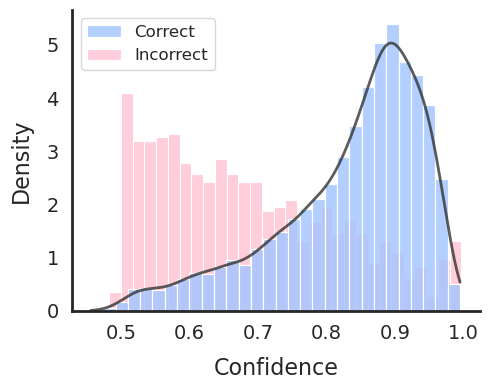

In [9]:
# Confidence values are plotted as histograms:
# - Light blue: correct or appropriate IDK (computed `wise_conf`)
# - Light red: incorrect or unnecessarily discarded (computed `foolish_conf`)
correct_scores, incorrect_scores = plot_bonus_tsk_confidence_distribution(mnist_idk_multi_classifier, test_loader_classifier, DEVICE)

From visual inspection, observing also the bars that overlap transparently, it is clear that this classifier still makes errors more frequently for confidence values below $0.70-0.73$, which therefore represents our primary guess. Compared to the plot that would be expected for a baseline drawn without ‘IDK’ labels (with few persistent errors but low frequency and predictions with high confidence and higher frequency), the classifier seems to have better calibrated its confidence but at the expense of more errors.

---

#### Coverage-vs-Accuracy Analysis for IDK Threshold Selection

After visually inspecting the confidence distribution, the next step is to quantify how the choice of an IDK threshold affects the model’s accuracy and data coverage, by deferring inconfident samples to an expert, aka labelling them as `IDK`. This is a heuristic **Selective Classification** analysis: instead of showing the risk of incorrect classification, we measure the accuracy on confidently classified samples while controlling how many are deferred. We define two key metrics:

- **Coverage**: Fraction of samples the model is confident enough to classify (i.e., not labeled as `IDK`).
- **Accuracy on accepted samples**: Fraction of `non-IDK` predictions that are correct.

The `calculate_idk_metrics` function sweeps over a range of confidence thresholds. For each threshold, it computes:
1. Accuracy on samples with confidence above the threshold.
2. Coverage of accepted samples above the threshold.

By plotting accuracy against coverage using zplot_bonus_tsk_acc_coverage_curvez, we can identify the “elbow”—the threshold where accuracy stops increasing significantly despite reducing coverage. This represents a sweet spot for the IDK cascade, maximizing correctness while minimizing the number of samples deferred to `IDK`.

Example usage:

```python
thresholds, accuracies, coverages = calculate_idk_metrics(correct_scores, incorrect_scores, thresholds=np.linspace(.1, .94, 100))
final_acc, final_cov = plot_bonus_tsk_acc_coverage_curve(coverages, accuracies)
print(f"The model is stable up to {final_cov:.1%} coverage with {final_acc:.2%} accuracy.")

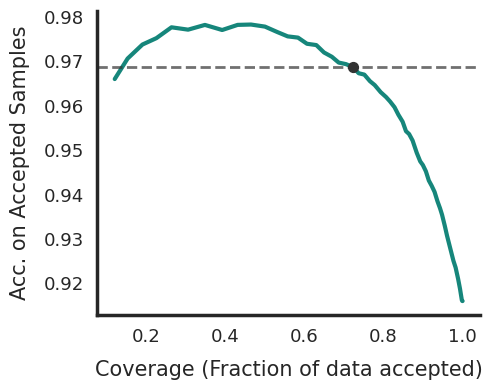

The model is stable up to 72.2% coverage with 96.87% accuracy.


In [10]:
# Run the sweep
thresholds, accuracies, coverages = calculate_idk_metrics(correct_scores, incorrect_scores, thresholds = np.linspace(.1, .94, 100))
# Plot and find the elbow
final_acc, final_cov = plot_bonus_tsk_acc_coverage_curve(coverages, accuracies)

print(f"The model is stable up to {final_cov:.1%} coverage with {final_acc:.2%} accuracy.")

Interestingly, unlike a naive baseline (where errors mostly occur at low confidence), our classifier is highly confident yet wrong on very few samples (left side of the curve). As a result, the accuracy rises quickly and reaches high values with minimal coverage loss, but near maximum coverage it does not remain constant; instead, it fluctuates slightly, increasing and dropping.

After inspecting the coverage-vs-accuracy curve, we select a target accuracy (slightly more conservative than the elbow point) and use `find_optimal_threshold` to pick the confidence threshold. This threshold determines which predictions weill further be deferred to `IDK`, besides the already predicted 11th class. We define: We define:
- Errors caught: Predictions below the threshold that would have been wrong are safely deferred.
- Correct predictions sacrificed: Predictions below the threshold that would have been correct are also deferred, representing a trade-off between uncertainty and coverage.

For our analysis, we target $96.5\%$ accuracy, slightly below the elbow at $\sim 96.87\%$, to be conservative when applying this `IDK` policy to generated MNIST images, where true labels are unavailable.

In [14]:
TARGET_ACC = 0.965
best_t = find_optimal_threshold(thresholds, accuracies, target_accuracy=TARGET_ACC)
print(f"Policy: Threshold set at {best_t:.4f} to achieve {TARGET_ACC*100}% accuracy.")

# How many errors would we have caught?
errors_caught = sum(1 for c in incorrect_scores if c < best_t)
total_errors = len(incorrect_scores)

# How many correct predictions would we "waste" by calling them IDK?
correct_rejected = sum(1 for c in correct_scores if c < best_t)
total_correct = len(correct_scores)

print(f"At threshold {best_t}:")
print(f"- Avoided {errors_caught}/{total_errors} errors ({errors_caught/total_errors:.1%})")
print(f"- Sacrificed {correct_rejected}/{total_correct} correct samples ({correct_rejected/total_correct:.1%})")

# Set IDK threshold for final cascade using the optimal value from the proxy analysis
IDK_THRESHOLD = best_t

Policy: Threshold set at 0.7448 to achieve 96.5% accuracy.
At threshold 0.7448484848484848:
- Avoided 576/840 errors (68.6%)
- Sacrificed 1766/9160 correct samples (19.3%)


### Part 4

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# Define the directory where your images are stored
images_dir = os.path.abspath("results/eval_02_unconditional")

# Clean up existing FiftyOne dataset
dataset_name = "ddpm_unconditional_eval"
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

# Create a new dataset by importing the images from the directory
dataset = fo.Dataset.from_images_dir(images_dir, name=dataset_name)

# Generate predictions on the generated images by using the loader from disk
results = predict_with_cascaded_idk(
    mnist_idk_multi_classifier, 
    gen_loader_from_disk, 
    DEVICE, 
    threshold=IDK_THRESHOLD
)

# Add predictions to FiftyOne
# FiftyOne loads images in alphabetical order. ur results list is also ordered gen_000, gen_001... so they will match.
samples = dataset.sort_by("filepath")

print(f"Applying cascaded IDK predictions to {len(samples)} generated samples...")

for sample, res in zip(samples, results):
    # Raw classifier output (before thresholding)
    sample["pseudo_label"] = fo.Classification(
        label=str(res["raw_prediction"]),
        confidence=res["confidence"]
    )

    # Final cascaded prediction (after IDK logic)
    sample["thresholded_classifier"] = fo.Classification(
        label=str(res["final_prediction"]),
        confidence=res["confidence"]
    )

    # Metadata for filtering
    sample["rejection_type"] = res["rejection_type"]
    sample["is_idk"] = (res["final_prediction"] == "IDK")

    # Store pseudo-label explicitly 
    # if res["pseudo_label"] is not None:
    #     sample["pseudo_label"] = str(res["pseudo_label"])

    sample.save()

# Launch the App
session = fo.launch_app(dataset)

 100% |█████████████████| 500/500 [82.5ms elapsed, 0s remaining, 6.1K samples/s]   
Applying cascaded IDK predictions to 500 generated samples...


Now, we can export the FiftyOne dataset locally and prepare it for upload to the Hugging Face Dataset repository at [vanessaguarino/mnist-confidence-thresholded-evaluation](https://huggingface.co/datasets/vanessaguarino/mnist-confidence-thresholded-evaluation) using the Hugging Face CLI workflow. This ensures that all generated images, pseudo-labels, thresholded predictions with the IDK cascade, and the `is_idk` filter are preserved.

For detailed steps on exporting the dataset and creating/uploading the Hugging Face repository, please refer to the `README.md` or the notebook `05_b_*.ipynb` in this folder.

In [15]:
# Define the export path and a metadata.jsonl file so the scores show up in the table
export_dir = os.path.join(ROOT_DATA, "mnist_idk_evaluation_export")

# Perform the export
# This creates a folder containing:
# - data/ (the images)
# - samples.json (all metrics: clip_score, uniqueness, representativeness, embeddings)
# - metadata.json (dataset info)
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True
)

print(f"FiftyOne dataset exported to {export_dir}")

Exporting samples...
   0% ||-------------------|   0/500 [372.8us elapsed, ? remaining, ? docs/s] 

 100% |████████████████████| 500/500 [85.6ms elapsed, 0s remaining, 5.8K docs/s] 
FiftyOne dataset exported to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/data/mnist_idk_evaluation_export


### Part 5 — Verify Data Download from Hugging Face and into FiftyOne Dataset Object

Finally, we verify that the dataset was correctly uploaded to Hugging Face by downloading the snapshot and loading it back into a FiftyOne dataset object. This allows us to inspect the exported images, embeddings, and evaluation metrics just as before.

We first download the dataset snapshot using `snapshot_download`, then create a new FiftyOne dataset from the local files. Finally, we launch the FiftyOne app to visually confirm that all samples, metadata, and computed metrics have been preserved correctly.

Fetching 504 files:   0%|          | 0/504 [00:00<?, ?it/s]

Importing samples...
 100% |█████████████████| 500/500 [10.3ms elapsed, 0s remaining, 48.7K samples/s]      
Name:        restored_flower_assessment
Media type:  image
Num samples: 500
Persistent:  False
Tags:        []
Sample fields:
    id:                     fiftyone.core.fields.ObjectIdField
    filepath:               fiftyone.core.fields.StringField
    tags:                   fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:               fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:             fiftyone.core.fields.DateTimeField
    last_modified_at:       fiftyone.core.fields.DateTimeField
    pseudo_label:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    thresholded_classifier: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    rejection_type:         fiftyone.core.fields.StringField
    is_idk:                 fiftyone


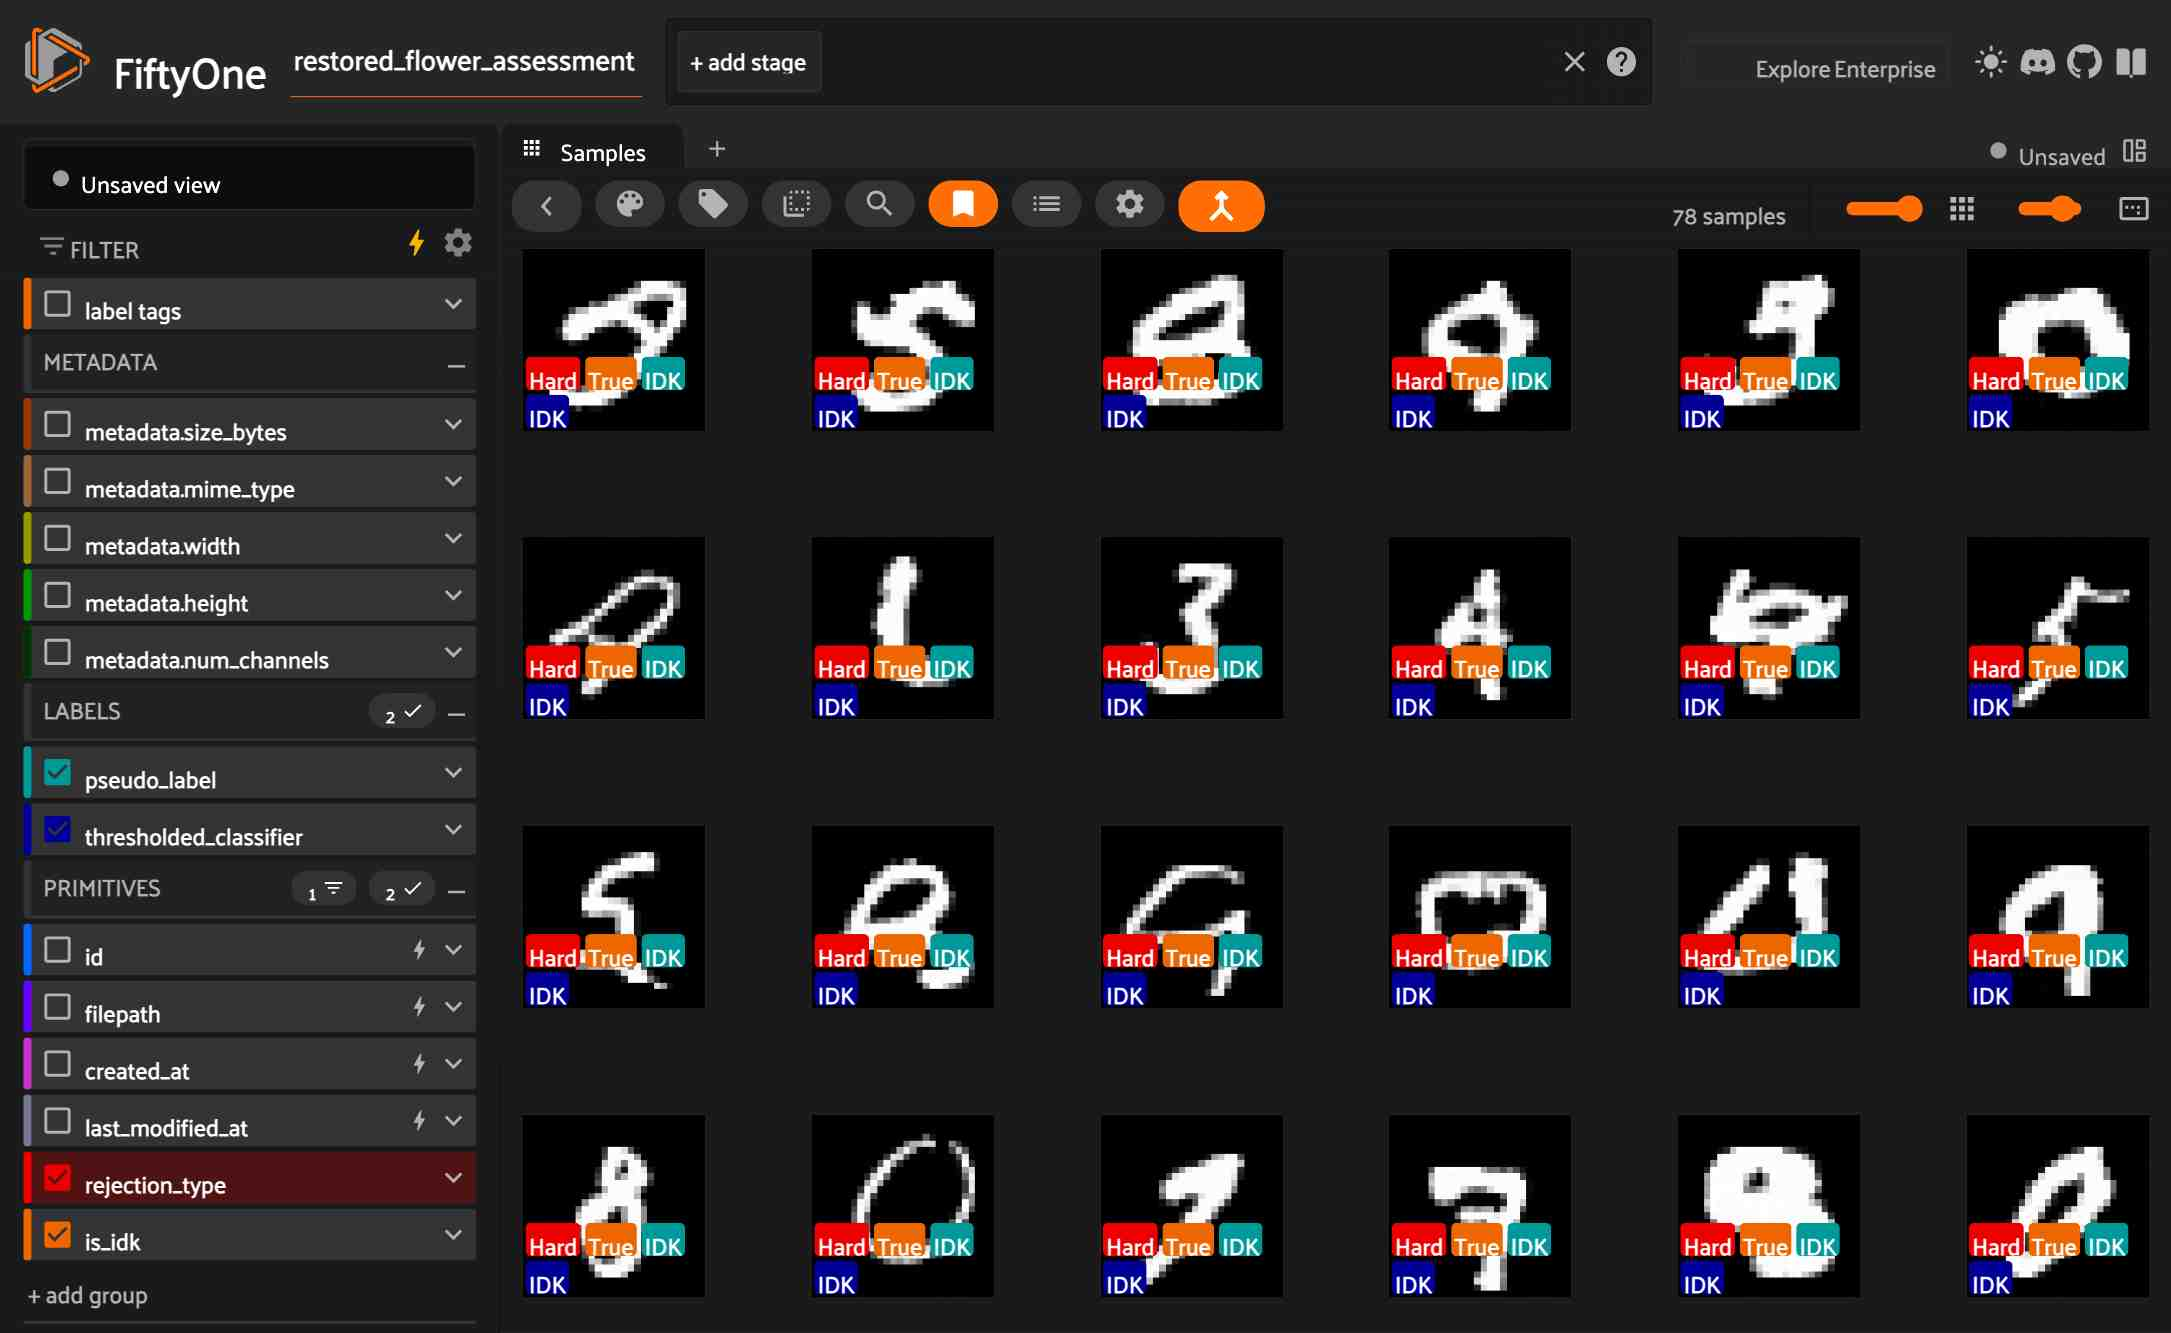

Dataset:          restored_flower_assessment
Media type:       image
Num samples:      500
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [ ]:
# Download the snapshot from Hugging Face
local_dir = snapshot_download(repo_id=HF_REPO_ID, repo_type="dataset")
fiftyone_dataset_name = "restored_flower_assessment"

if fiftyone_dataset_name in fo.list_datasets():
    fo.delete_dataset(fiftyone_dataset_name)
    
# test_data_dir = os.path.join(local_dir, "test")

# Load it back into FiftyOne
restored_dataset = fo.Dataset.from_dir(
    dataset_dir=local_dir, # Also, local_dir would work, as it is a copy of test folder
    dataset_type=fo.types.FiftyOneDataset,
    name=fiftyone_dataset_name
)

# Verify
print(restored_dataset)
fo.launch_app(restored_dataset)